In [4]:

from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical


from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import pickle
import nltk
import re
from nltk.stem import PorterStemmer

import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud

# LOAD DATA

In [5]:
train_data = pd.read_csv("train.txt", header=None, sep=";", names=["Comment", "Emotion"], encoding="utf-8")

train_data['length'] = [len(x) for x in train_data['Comment']]

In [6]:
train_data

,Comment,Emotion,length
0,i didnt feel humiliated,sadness,23
1,i can go from feeling so hopeless to so damned...,sadness,108
2,im grabbing a minute to post i feel greedy wrong,anger,48
3,i am ever feeling nostalgic about the fireplac...,love,92
4,i am feeling grouchy,anger,20
...,...,...,...
15995,i just had a very brief time in the beanbag an...,sadness,101
15996,i am now turning and i feel pathetic that i am...,sadness,102
15997,i feel strong and good overall,joy,30
15998,i feel like this was such a rude comment and i...,anger,59


In [7]:
train_data.shape

(16000, 3)

In [8]:
train_data.isnull().sum()

Comment    0
Emotion    0
length     0
dtype: int64

In [9]:
train_data.duplicated().sum()

1

# EDA

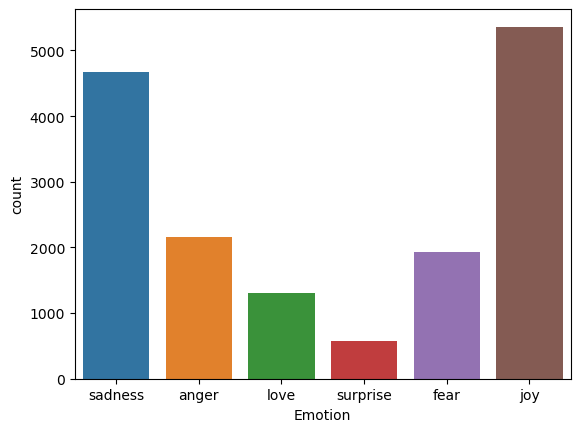

In [10]:
sns.countplot(x = train_data['Emotion'])
plt.show()

C:\Users\Shubhechha\anaconda_new\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


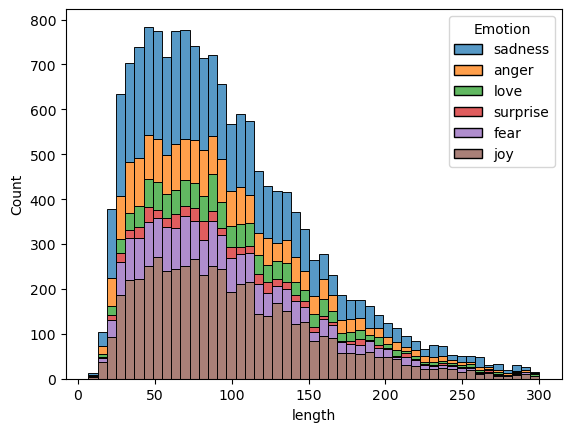

In [11]:
df2 = train_data.copy()
df2['length'] = [len(x) for x in df2['Comment']]

# Converting the 'length' column to a numpy array
length_values = df2['length'].values

# Use sns.histplot
sns.histplot(data=df2, x='length', hue='Emotion', multiple='stack')

plt.show()

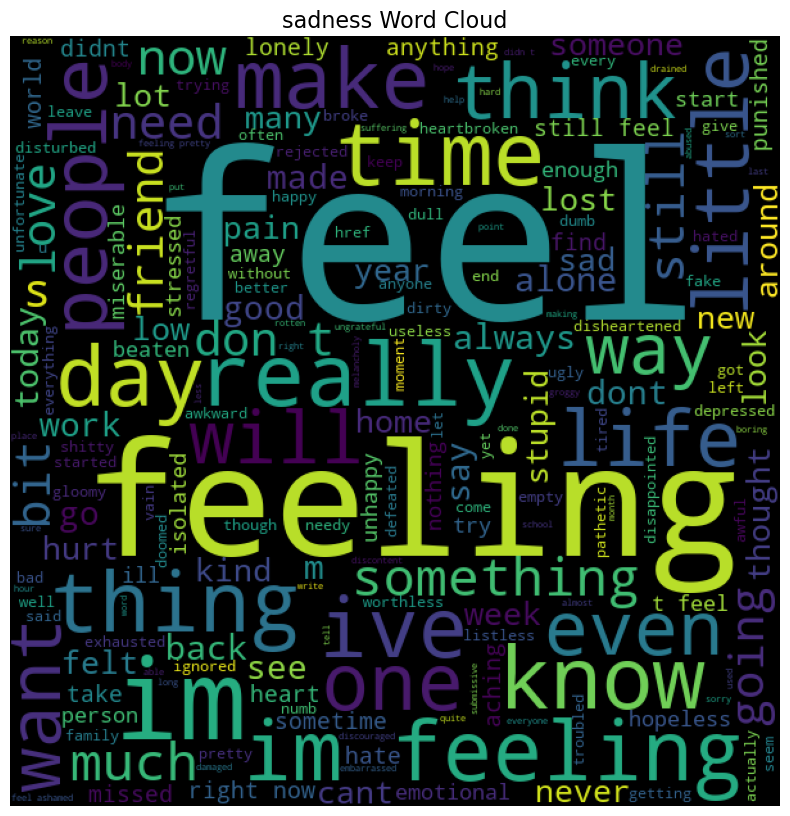

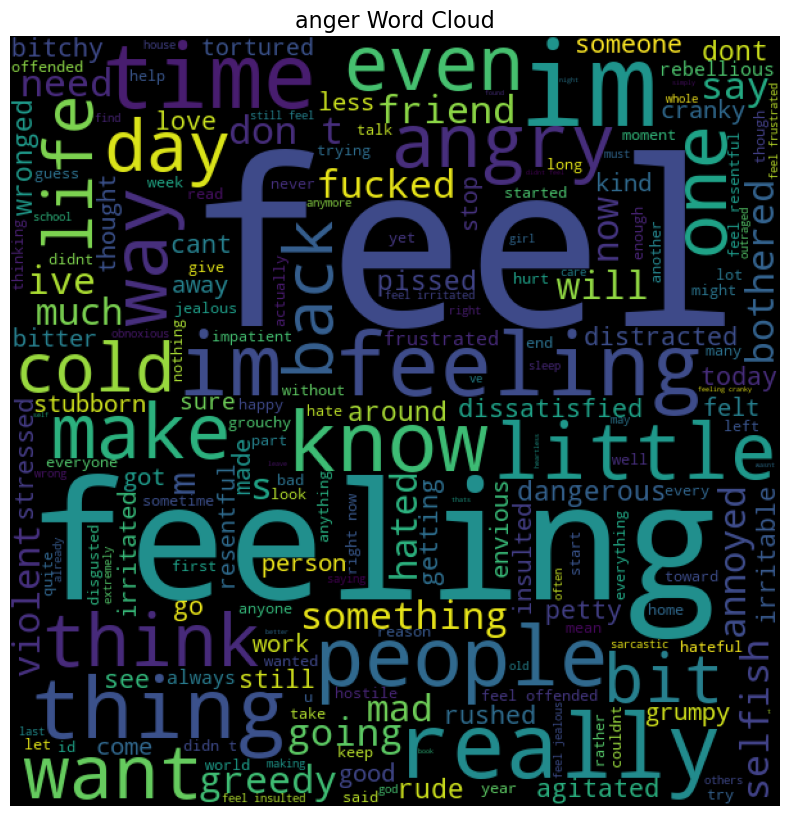

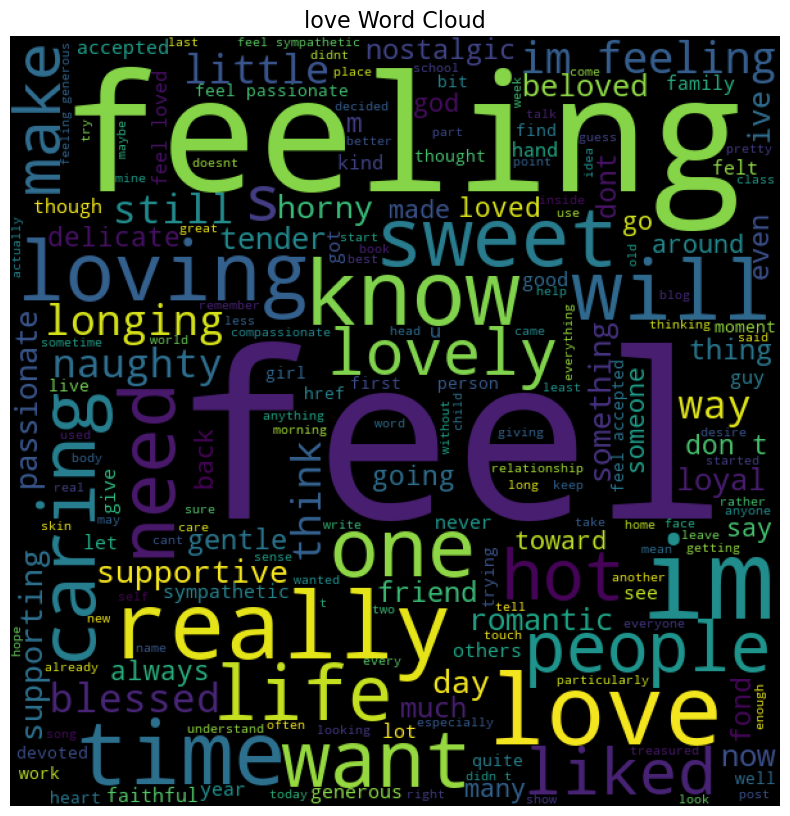

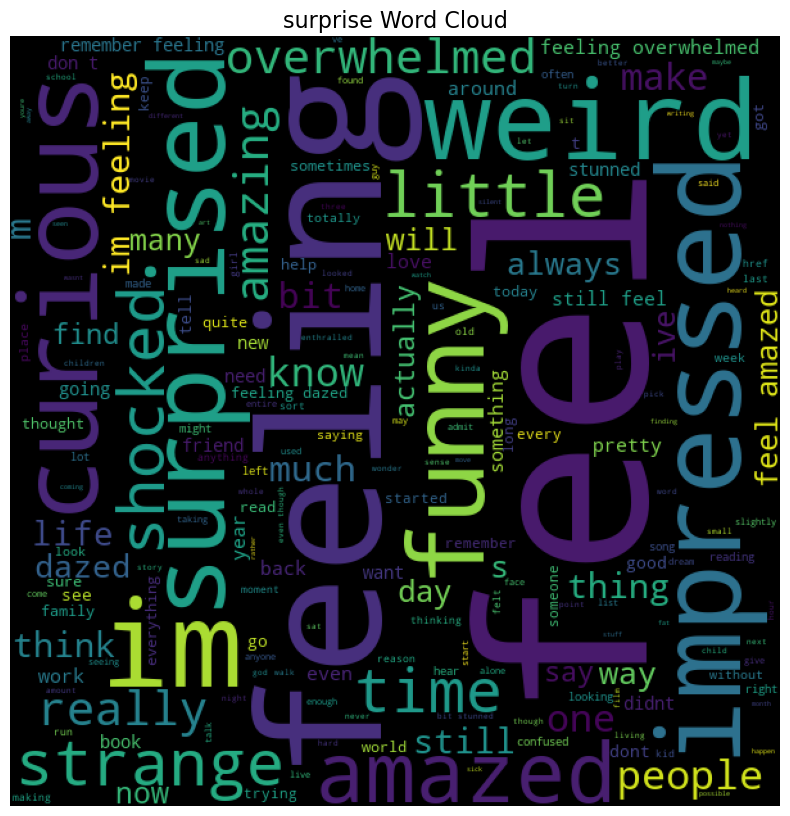

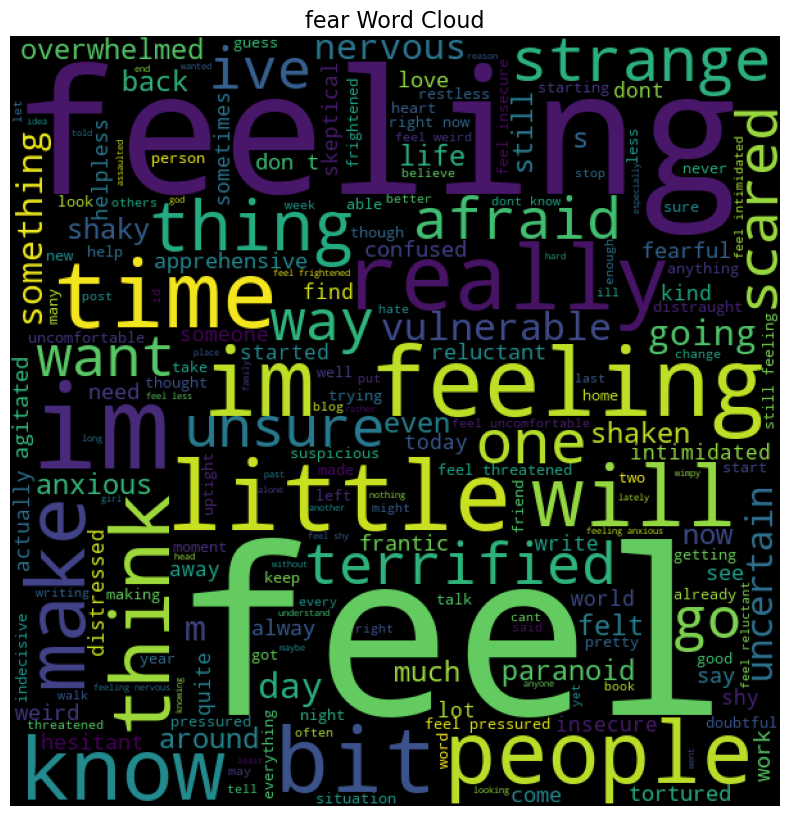

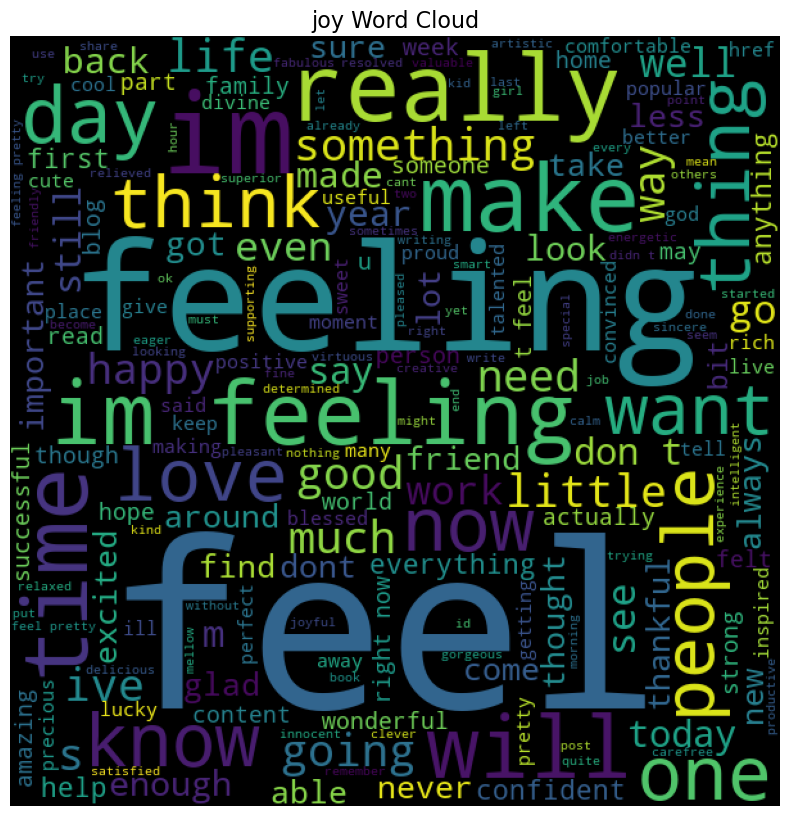

In [12]:
# Words cloud for each emotions
def words_cloud(wordcloud, df):
    plt.figure(figsize=(10, 10))
    plt.title(df+' Word Cloud', size = 16)
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");
emotions_list = train_data['Emotion'].unique()
for emotion in emotions_list:
    text = ' '.join([sentence for sentence in train_data.loc[train_data['Emotion'] == emotion,'Comment']])
    wordcloud = WordCloud(width = 600, height = 600).generate(text)
    words_cloud(wordcloud, emotion)

# DATA PREPROCESSING

In [13]:
lb = LabelEncoder()
train_data['Emotion'] = lb.fit_transform(train_data['Emotion'])

In [14]:
train_data

,Comment,Emotion,length
0,i didnt feel humiliated,4,23
1,i can go from feeling so hopeless to so damned...,4,108
2,im grabbing a minute to post i feel greedy wrong,0,48
3,i am ever feeling nostalgic about the fireplac...,3,92
4,i am feeling grouchy,0,20
...,...,...,...
15995,i just had a very brief time in the beanbag an...,4,101
15996,i am now turning and i feel pathetic that i am...,4,102
15997,i feel strong and good overall,2,30
15998,i feel like this was such a rude comment and i...,0,59


# MODEL BUILDING

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [16]:
df = train_data.copy()

In [17]:
df

,Comment,Emotion,length
0,i didnt feel humiliated,4,23
1,i can go from feeling so hopeless to so damned...,4,108
2,im grabbing a minute to post i feel greedy wrong,0,48
3,i am ever feeling nostalgic about the fireplac...,3,92
4,i am feeling grouchy,0,20
...,...,...,...
15995,i just had a very brief time in the beanbag an...,4,101
15996,i am now turning and i feel pathetic that i am...,4,102
15997,i feel strong and good overall,2,30
15998,i feel like this was such a rude comment and i...,0,59


In [19]:
# Data cleaning and preprocessing
# Download NLTK stopwords
#nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))
def clean_text(text):
    stemmer = PorterStemmer()
    text = re.sub("[^a-zA-Z]", " ", text)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stopwords]
    return " ".join(text)

df['cleaned_comment'] = df['Comment'].apply(clean_text)

In [20]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_comment'],df['Emotion'],test_size=0.2,random_state=42)

In [21]:
# Vectorization using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [23]:
# Multi-class classification using different algorithms
classifiers = {
    "Multinomial Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(),
}

for name, clf in classifiers.items():
    print(f"\n===== {name} =====")
    clf.fit(X_train_tfidf, y_train)
    y_pred_tfidf = clf.predict(X_test_tfidf)
    accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)
    print(f"\nAccuracy using TF-IDF: {accuracy_tfidf}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred_tfidf))


===== Multinomial Naive Bayes =====

Accuracy using TF-IDF: 0.655
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.31      0.46       427
           1       0.91      0.24      0.38       397
           2       0.58      0.98      0.73      1021
           3       1.00      0.03      0.06       296
           4       0.70      0.91      0.79       946
           5       1.00      0.01      0.02       113

    accuracy                           0.66      3200
   macro avg       0.85      0.41      0.41      3200
weighted avg       0.76      0.66      0.58      3200


===== Logistic Regression =====

Accuracy using TF-IDF: 0.8296875
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.79      0.83       427
           1       0.84      0.73      0.78       397
           2       0.78      0.94      0.85      1021
           3       0.80      0.49      0.61       296
      

In [25]:
# selecting model
lg = LogisticRegression()
lg.fit(X_train_tfidf, y_train)
lg_y_pred = lg.predict(X_test_tfidf)

C:\Users\Shubhechha\anaconda_new\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [26]:
def predict_emotion(input_text):
    cleaned_text = clean_text(input_text)
    input_vectorized = tfidf_vectorizer.transform([cleaned_text])

    # Predict emotion
    predicted_label = lg.predict(input_vectorized)[0]
    predicted_emotion = lb.inverse_transform([predicted_label])[0]
    label =  np.max(lg.predict(input_vectorized))

    return predicted_emotion,label

# Example usage 
sentences = [
            "i didnt feel humiliated",
            "i feel strong and good overall",
            "im grabbing a minute to post i feel greedy wrong",
            "He was speechles when he found out he was accepted to this new job",
            "This is outrageous, how can you talk like that?",
            "I feel like im all alone in this world",
            "He is really sweet and caring",
            "You made me very crazy",
            "i am ever feeling nostalgic about the fireplace i will know that it is still on the property",
            "i am feeling grouchy",
            "He hates you"
            ]
for sentence in sentences:
    print(sentence)
    pred_emotion, label = predict_emotion(sentence)
    print("Prediction :",pred_emotion)
    print("Label :",label)
    print("================================================================")

i didnt feel humiliated
Prediction : sadness
Label : 4
i feel strong and good overall
Prediction : joy
Label : 2
im grabbing a minute to post i feel greedy wrong
Prediction : anger
Label : 0
He was speechles when he found out he was accepted to this new job
Prediction : joy
Label : 2
This is outrageous, how can you talk like that?
Prediction : anger
Label : 0
I feel like im all alone in this world
Prediction : sadness
Label : 4
He is really sweet and caring
Prediction : love
Label : 3
You made me very crazy
Prediction : sadness
Label : 4
i am ever feeling nostalgic about the fireplace i will know that it is still on the property
Prediction : love
Label : 3
i am feeling grouchy
Prediction : anger
Label : 0
He hates you
Prediction : anger
Label : 0


In [27]:
# save files
import pickle
pickle.dump(lg,open("logistic_regresion.pkl",'wb'))
pickle.dump(lb,open("label_encoder.pkl",'wb'))
pickle.dump(tfidf_vectorizer,open("tfidf_vectorizer.pkl",'wb'))

In [28]:
import sklearn
print(sklearn.__version__)

1.2.2


# APPLYING LSTM

In [30]:
# Text cleaning function
def text_cleaning(df, column, vocab_size, max_len):
    stemmer = PorterStemmer()
    corpus = []

    for text in df[column]:
        text = re.sub("[^a-zA-Z]", " ", text)
        text = text.lower()
        text = text.split()
        text = [stemmer.stem(word) for word in text if word not in stopwords]
        text = " ".join(text)
        corpus.append(text)

    one_hot_word = [one_hot(input_text=word, n=vocab_size) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word, maxlen=max_len, padding='pre')
    return pad

# Text cleaning and encoding
x_train = text_cleaning(train_data, "Comment", vocab_size=11000, max_len=300)
y_train = to_categorical(train_data["Emotion"])

In [31]:
# Build and compile the model
model = Sequential()
model.add(Embedding(input_dim=11000, output_dim=150, input_length=300))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
callback = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
model.fit(x_train, y_train, epochs=10, batch_size=64, verbose=1, callbacks=[callback])

Epoch 1/10


C:\Users\Shubhechha\anaconda_new\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 67s 259ms/step - accuracy: 0.3003 - loss: 1.6593
Epoch 2/10


C:\Users\Shubhechha\anaconda_new\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


250/250 ━━━━━━━━━━━━━━━━━━━━ 67s 267ms/step - accuracy: 0.6419 - loss: 1.0230
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 69s 277ms/step - accuracy: 0.7882 - loss: 0.5454
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 72s 286ms/step - accuracy: 0.9108 - loss: 0.2808
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 71s 283ms/step - accuracy: 0.9364 - loss: 0.1951
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 67s 266ms/step - accuracy: 0.9520 - loss: 0.1463
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 66s 262ms/step - accuracy: 0.9598 - loss: 0.1204
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 66s 265ms/step - accuracy: 0.9628 - loss: 0.1011
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 66s 263ms/step - accuracy: 0.9716 - loss: 0.0808
Epoch 10/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 65s 260ms/step - accuracy: 0.9721 - loss: 0.0773


# PREDICTION 

In [32]:
# Text cleaning function
def sentence_cleaning(sentence):
    stemmer = PorterStemmer()
    corpus = []
    text = re.sub("[^a-zA-Z]", " ", sentence)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stopwords]
    text = " ".join(text)
    corpus.append(text)
    one_hot_word = [one_hot(input_text=word, n=11000) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word, maxlen=300, padding='pre')
    return pad

# load model and predict 
sentences = [
            "i feel strong and good overall",
            "im grabbing a minute to post i feel greedy wrong",
            "He was speechles when he found out he was accepted to this new job",
            "This is outrageous, how can you talk like that?",
            "I feel like im all alone in this world",
            "He is really sweet and caring",
            "You made me very crazy",
            "i am ever feeling nostalgic about the fireplace i will know that it is still on the property",
            "i am feeling grouchy",
            "He hates you"
            ]
for sentence in sentences:
    print(sentence)
    sentence = sentence_cleaning(sentence)
    result = lb.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
    proba =  np.max(model.predict(sentence))
    print(f"{result} : {proba}\n\n")

i feel strong and good overall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
joy : 0.9994452595710754


im grabbing a minute to post i feel greedy wrong
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
anger : 0.9978440999984741


He was speechles when he found out he was accepted to this new job
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
joy : 0.6392267346382141


This is outrageous, how can you talk like that?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
anger : 0.946452260017395


I feel like im all alone in this world
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
sadness : 0.984167754650116


He is really sweet and caring
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
love : 0.6642870903015137


You made me very crazy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
joy : 0.561

# Save the model and files


In [33]:
model.save('model1.h5')

# Save the LabelEncoder
with open('lb1.pkl', 'wb') as f:
    pickle.dump(lb, f)

# Save vocabulary size and max length
vocab_info = {'vocab_size': 11000, 'max_len': 300}
with open('vocab_info.pkl', 'wb') as f:
    pickle.dump(vocab_info, f)

In [34]:
# use this version
import tensorflow
import keras
print(keras.__version__)
print(tensorflow.__version__)

3.3.3
2.16.1


In [ ]:
SKLEARN-1.2.2